In [1]:
%load_ext autoreload
%autoreload 2
from main  import *

In [3]:
opt = Config()    
opt.caption_data_path = 'caption.pth' # 原始数据
opt.test_img = 'img/example.jpeg' # 输入图片
opt.use_gpu = False  # 是否使用GPU(没必要)
opt.model_ckpt='caption_0914_1947' # 预训练的模型

if opt.use_gpu:
    context.set_context(mode=context.GRAPH_MODE, device_target="GPU")
else:
    context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

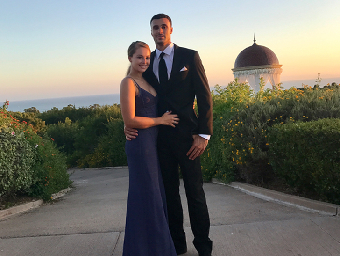

In [4]:
# 数据预处理
data = mindspore.load_checkpoint(opt.caption_data_path)
word2ix,ix2word = data['word2ix'],data['ix2word']

IMAGENET_MEAN =  [0.485, 0.456, 0.406]
IMAGENET_STD =  [0.229, 0.224, 0.225]
normalize = ds.vision.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
transforms = ds.transforms.Compose([
    ds.vision.Decode(),
    ds.vision.Resize(opt.scale_size),
    ds.vision.CenterCrop(opt.img_size),
    ds.vision.ToTensor(),
    normalize
])
img_ = Image.open(opt.test_img)
img = transforms(img_).unsqueeze(0)
img_.resize((int(img_.width*256/img_.height),256))

In [5]:
# 用resnet50来提取图片特征
# 如果本地没有预训练的模型文件，会自动下载
resnet50 = mindcv.models.resnet50(True).eval()
del resnet50.fc
resnet50.fc = lambda x:x
img_feats = resnet50(Tensor(img))

In [6]:
# Caption模型
model = CaptionModel(opt,word2ix,ix2word)
model = model.load(opt.model_ckpt).eval()

results = model.generate(img_feats.data[0])
print('\r\n'.join(results))

一个 穿着 西装 的 男人 和 一个 穿着 裙子 的 女人 站 在 道路 上 </EOS>
一个 穿着 西装 的 男人 搂 着 一个 穿着 裙子 的 女人 站 在 道路 上 </EOS>
一个 穿着 西装 的 男人 和 一个 穿着 裙子 的 女人 站 在 室外 </EOS>
